In [1]:
library(SingleCellExperiment)
library(scater)
library(scran)

library(ComplexHeatmap)
library(viridis)
library(RColorBrewer)

library(biclust)

library(ggthemes)
library(circlize)
library("gridExtra")

set.seed(2358)
options(repr.plot.width = 15, repr.plot.height = 10)


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
sim_truth <- function(splatter_sim,                                                                                                                                                                                                                                                 
                      factor_cutoff = 1,                                                                                                                                                                                                                                            
                      no_overlap = TRUE){                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                    
  rd <- as.data.frame(rowData(splatter_sim))                                                                                                                                                                                                                                        
  cd <- as.data.frame(colData(splatter_sim))                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                    
  de_fac <- dplyr::select(rd, starts_with("DEFacGroup"))                                                                                                                                                                                                                            
  colnames(de_fac) <- gsub("DEFacGroup", "Group", colnames(de_fac))                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                    
  de_fac <- as.matrix(de_fac)                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                                    
  if (any(de_fac < 1)) stop("Only simulated datesets with no downregulated genes allowed.")                                                                                                                                                                                         
  de_genes <- de_fac > factor_cutoff                                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                    
  if(isTRUE(no_overlap)){                                                                                                                                                                                                                                                           
    de_bool <- matrix(FALSE,                                                                                                                                                                                                                                                        
                      nrow = nrow(de_fac),                                                                                                                                                                                                                                          
                      ncol = ncol(de_fac),                                                                                                                                                                                                                                          
                      dimnames = list(rownames(de_fac),                                                                                                                                                                                                                             
                                      colnames(de_fac)))                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                                    
    for (x in seq_len(nrow(de_fac))) {                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                    
      if(any(de_genes[x,])) {                                                                                                                                                                                                                                                       
        vals <- de_fac[x,][de_genes[x,]]                                                                                                                                                                                                                                            
        max_val <- which(abs(vals) == max(abs(vals)))                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                    
        de_bool[x, which(de_fac[x,] == vals[max_val])] <- TRUE                                                                                                                                                                                                                      
      }else {                                                                                                                                                                                                                                                                       
        next                                                                                                                                                                                                                                                                        
      }                                                                                                                                                                                                                                                                             
    }                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                    
    de_genes <- de_bool                                                                                                                                                                                                                                                             
  }                                                                                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                    
  cell_clusts <- model.matrix(~Group-1, data=cd) == 1                                                                                                                                                                                                                               
  colnames(cell_clusts) <- gsub("GroupGroup", "Group", colnames(cell_clusts))                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                                    
  RowxNumber <- de_genes                                                                                                                                                                                                                                                            
  NumberxCol <- t(cell_clusts)                                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                                    
 if(isTRUE(no_overlap)){                                                                                                                                                                                                                                                            
   Number <- length(intersect(rownames(NumberxCol), colnames(RowxNumber)))                                                                                                                                                                                                          
 } else {                                                                                                                                                                                                                                                                           
   Number <- length(union(rownames(NumberxCol), colnames(RowxNumber)))                                                                                                                                                                                                              
 }                                                                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                    
  bic <- new("Biclust", "Parameters" = list("Splatter_Params" = splatter_sim@metadata$Params),                                                                                                                                                                                      
                       "RowxNumber" = RowxNumber,                                                                                                                                                                                                                                   
                       "NumberxCol" = NumberxCol,                                                                                                                                                                                                                                   
                       "Number" = Number,                                                                                                                                                                                                                                           
                       "info" = list("splatter simulated data"))                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                    
}

get_gene_clusters <- function(splatter_sim) {                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                                    
  rd <- as.data.frame(rowData(splatter_sim))                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                    
  de_fac <- dplyr::select(rd, starts_with("DEFacGroup"))                                                                                                                                                                                                                            
  de_fac <- as.matrix(de_fac)                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                                    
  rMs <- rowMaxs(de_fac)                                                                                                                                                                                                                                                            
  idxs <- purrr::map(seq_len(nrow(de_fac)), function(x) which(de_fac[x,] == rMs[x]))                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                    
  de_genes <- de_fac > 1 | de_fac < 1 # doesnt consider that gene can be DE in 2 groups                                                                                                                                                                                             
  de_bool <- matrix(FALSE,                                                                                                                                                                                                                                                          
                    nrow = nrow(de_fac),                                                                                                                                                                                                                                            
                    ncol = ncol(de_fac),                                                                                                                                                                                                                                            
                    dimnames = list(rownames(de_fac),                                                                                                                                                                                                                               
                                    colnames(de_fac)))                                                                                                                                                                                                                              
  for (x in seq_len(nrow(de_fac))) {                                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                    
    if(any(de_genes[x,])) {                                                                                                                                                                                                                                                         
    vals <- de_fac[x,][de_genes[x,]]                                                                                                                                                                                                                                                
    max_val <- which(abs(vals) == max(abs(vals)))                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                                    
    de_bool[x, which(de_fac[x,] == vals[max_val])] <- TRUE                                                                                                                                                                                                                          
    }else {                                                                                                                                                                                                                                                                         
      next                                                                                                                                                                                                                                                                          
    }                                                                                                                                                                                                                                                                               
  }                                                                                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                    
  grp <- as.numeric(de_bool %*% seq_len(ncol(de_bool)))                                                                                                                                                                                                                             
  grp_fact <- as.factor(grp)                                                                                                                                                                                                                                                        
  names(grp_fact) <- rownames(de_bool)                                                                                                                                                                                                                                              
                                                                                                                                                                                                                      
  return(grp_fact)                                                                                                                                                                                                                                                                       
}

# Draw heatmaps

For the heatmaps in Suppl. Figure 8 we simply load the simulated data sets, select the 2000 most variable genes, order the genes according to the cluster they belong to and draw the heatmaps.

## zeisel

In [3]:
zfiles <- list.files(path = "../Data/sim_data/zeisel/", 
                    pattern = ".rds",
                    full.names = TRUE)

In [4]:
zhm_list <- list()

for ( f in zfiles){
    
    sce <- readRDS(f)

    filenm <- gsub("_filtered.rds", "", basename(f))
    filenm <- gsub("-", ": ", filenm)
    filenm <- gsub("0_", "0.", filenm)
    filenm <- gsub("1_", "1.", filenm)
    filenm <- gsub("_", ", ", filenm)
    
    genevars <- modelGeneVar(sce, assay.type = "logcounts")

    chosen <- getTopHVGs(genevars, n = 2000, var.threshold = NULL)
    sce <- sce[chosen,]

    clust_order_cells <- c()
    un_cc <- sort(unique(sce$Group), decreasing = TRUE)
    for (i in seq_along(un_cc)){
        clust_order_cells <- c(clust_order_cells, which(sce$Group == un_cc[i]))
    }    
    
    gcs <- get_gene_clusters(splatter_sim = sce)
 
    clust_order_genes <- c()
    un_gc <- sort(unique(gcs), decreasing = TRUE)
    for (i in seq_along(un_gc)){
        clust_order_genes <- c(clust_order_genes, which(gcs== un_gc[i]))
    }   
    


    sce_sort <- sce[clust_order_genes, clust_order_cells]
    
    pal <- tableau_color_pal("Tableau 10")
    annocol <- pal(length(un_cc))
    names(annocol) <- as.character(un_cc)
    #annocol <- c(annocol, "Group0" = "#808080")
    annocol <- c(annocol, "Group0" = "white")

    gcs_sort <- gcs[clust_order_genes]    
    tmpnm <- names(gcs_sort)
    gcs_sort <- paste0("Group", gcs_sort)
    names(gcs_sort) <- tmpnm
    
    column_ha = HeatmapAnnotation(cluster = sce_sort$Group,
                                  col = list(cluster = annocol),
                                  show_legend = c(FALSE), 
                                  annotation_name_gp = gpar(fontsize = 0))

    
    row_ha = rowAnnotation(cluster =  gcs_sort,
                           col = list(cluster = annocol),
                           show_legend = c(FALSE),
                           annotation_name_gp= gpar(fontsize = 0))

    
    cnts <- as.matrix(logcounts(sce_sort))
   
    col_fun = colorRamp2(seq(quantile(cnts, 0.01), quantile(cnts, 0.99), length = 10), viridis(10))
    
    hm <- Heatmap(matrix = cnts,
                  col = col_fun,
                  name = " ",
                  cluster_columns = FALSE,
                  cluster_rows = FALSE,
                  show_row_names = FALSE,
                  show_column_names = FALSE,
                  column_title = filenm, 
                  top_annotation = column_ha,
                  left_annotation = row_ha,
                  use_raster = TRUE)
    
    
   zhm_list[[basename(f)]] <- hm 
}

    

    


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


## pbmc3k

In [5]:
pfiles <- list.files(path = "../Data/sim_data/pbmc3k/", 
                    pattern = ".rds",
                    full.names = TRUE)

In [6]:
phm_list <- list()

for ( f in pfiles){
    
    sce <- readRDS(f)

    
    filenm <- gsub("_filtered.rds", "", basename(f))
    filenm <- gsub("-", ": ", filenm)
    filenm <- gsub("0_", "0.", filenm)
    filenm <- gsub("1_", "1.", filenm)
    filenm <- gsub("_", ", ", filenm)

    
    genevars <- modelGeneVar(sce, assay.type = "logcounts")

    chosen <- getTopHVGs(genevars, n = 2000, var.threshold = NULL)
    sce <- sce[chosen,]

    clust_order_cells <- c()
    un_cc <- sort(unique(sce$Group), decreasing = TRUE)
    for (i in seq_along(un_cc)){
        clust_order_cells <- c(clust_order_cells, which(sce$Group == un_cc[i]))
    }    
    
    gcs <- get_gene_clusters(splatter_sim = sce)
 
    clust_order_genes <- c()
    un_gc <- sort(unique(gcs), decreasing = TRUE)
    for (i in seq_along(un_gc)){
        clust_order_genes <- c(clust_order_genes, which(gcs== un_gc[i]))
    }   
    


    sce_sort <- sce[clust_order_genes, clust_order_cells]
    
    pal <- tableau_color_pal("Tableau 10")
    annocol <- pal(length(un_cc))
    names(annocol) <- as.character(un_cc)
    #annocol <- c(annocol, "Group0" = "#808080")
    annocol <- c(annocol, "Group0" = "white")

    gcs_sort <- gcs[clust_order_genes]    
    tmpnm <- names(gcs_sort)
    gcs_sort <- paste0("Group", gcs_sort)
    names(gcs_sort) <- tmpnm
    
    column_ha = HeatmapAnnotation(cluster = sce_sort$Group,
                                  col = list(cluster = annocol),
                                  show_legend = c(FALSE), 
                                  annotation_name_gp = gpar(fontsize = 0))

    
    row_ha = rowAnnotation(cluster =  gcs_sort,
                           col = list(cluster = annocol),
                           show_legend = c(FALSE),
                           annotation_name_gp= gpar(fontsize = 0))

    
    cnts <- as.matrix(logcounts(sce_sort))
    
    col_fun = colorRamp2(seq(quantile(cnts, 0.01), quantile(cnts, 0.99), length = 10), viridis(10))
    
    
    hm <- Heatmap(matrix = cnts,
                  col = col_fun,
                  name = " ",
                  cluster_columns = FALSE,
                  cluster_rows = FALSE,
                  show_row_names = FALSE,
                  show_column_names = FALSE,
                  column_title = filenm,
                  top_annotation = column_ha,
                  left_annotation = row_ha,
                  use_raster = TRUE)
    
    
   phm_list[[basename(f)]] <- hm 
}

    

    


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


# Supplementary Figure 8

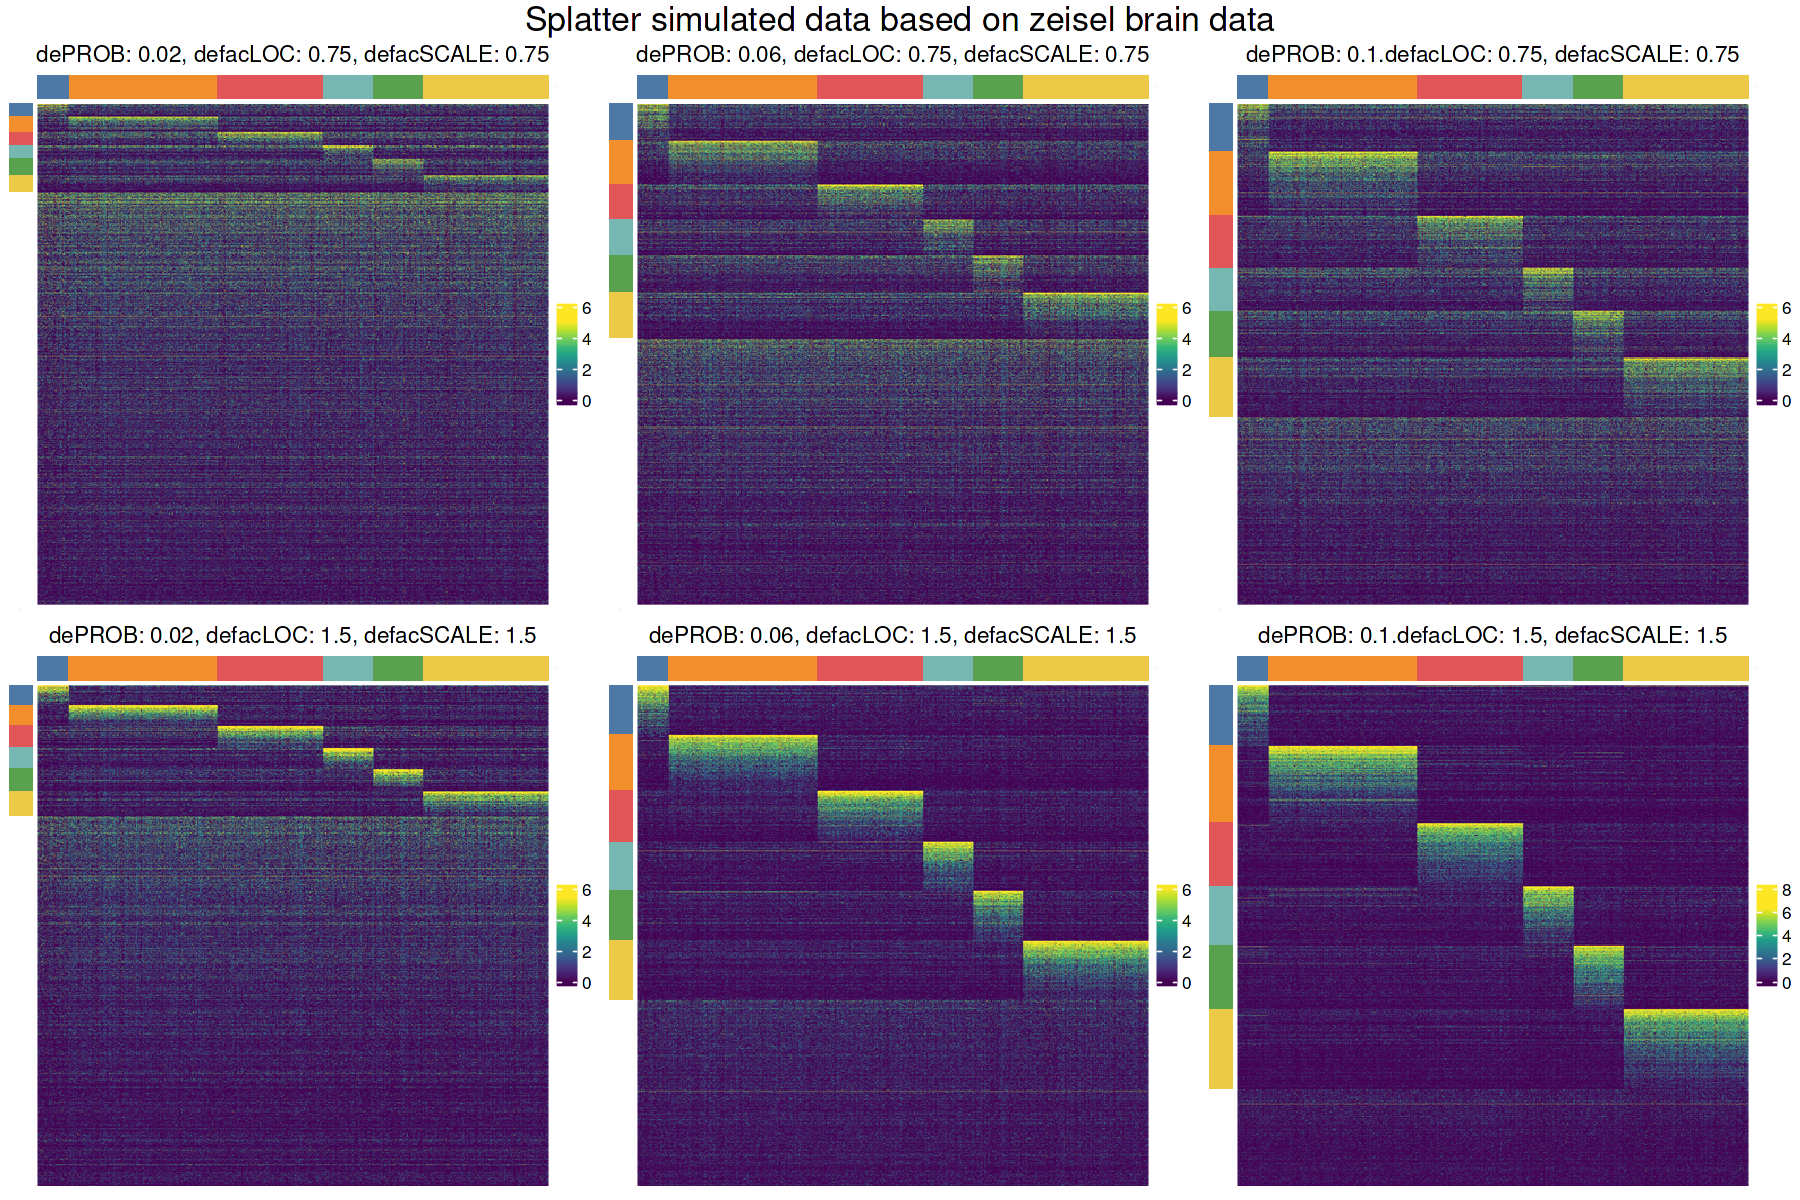

In [7]:

grob1 = grid.grabExpr(draw(zhm_list$`dePROB-0_02_defacLOC-0_75_defacSCALE-0_75_filtered.rds`)) 
grob2 = grid.grabExpr(draw(zhm_list$`dePROB-0_06_defacLOC-0_75_defacSCALE-0_75_filtered.rds`))
grob3 = grid.grabExpr(draw(zhm_list$`dePROB-0_1_defacLOC-0_75_defacSCALE-0_75_filtered.rds`))
grob4 = grid.grabExpr(draw(zhm_list$`dePROB-0_02_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))
grob5 = grid.grabExpr(draw(zhm_list$`dePROB-0_06_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))
grob6 = grid.grabExpr(draw(zhm_list$`dePROB-0_1_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))


# png("./img/zeisel_hms_3cols.png",
#     width = 1200,
#     height = 600,
#     unit = "px")

grid.arrange(grob1, grob2, grob3, 
            grob4, grob5, grob6,
            top = textGrob("Splatter simulated data based on zeisel brain data", gp=gpar(fontsize=20)),
            ncol=3, nrow =2)

# dev.off()

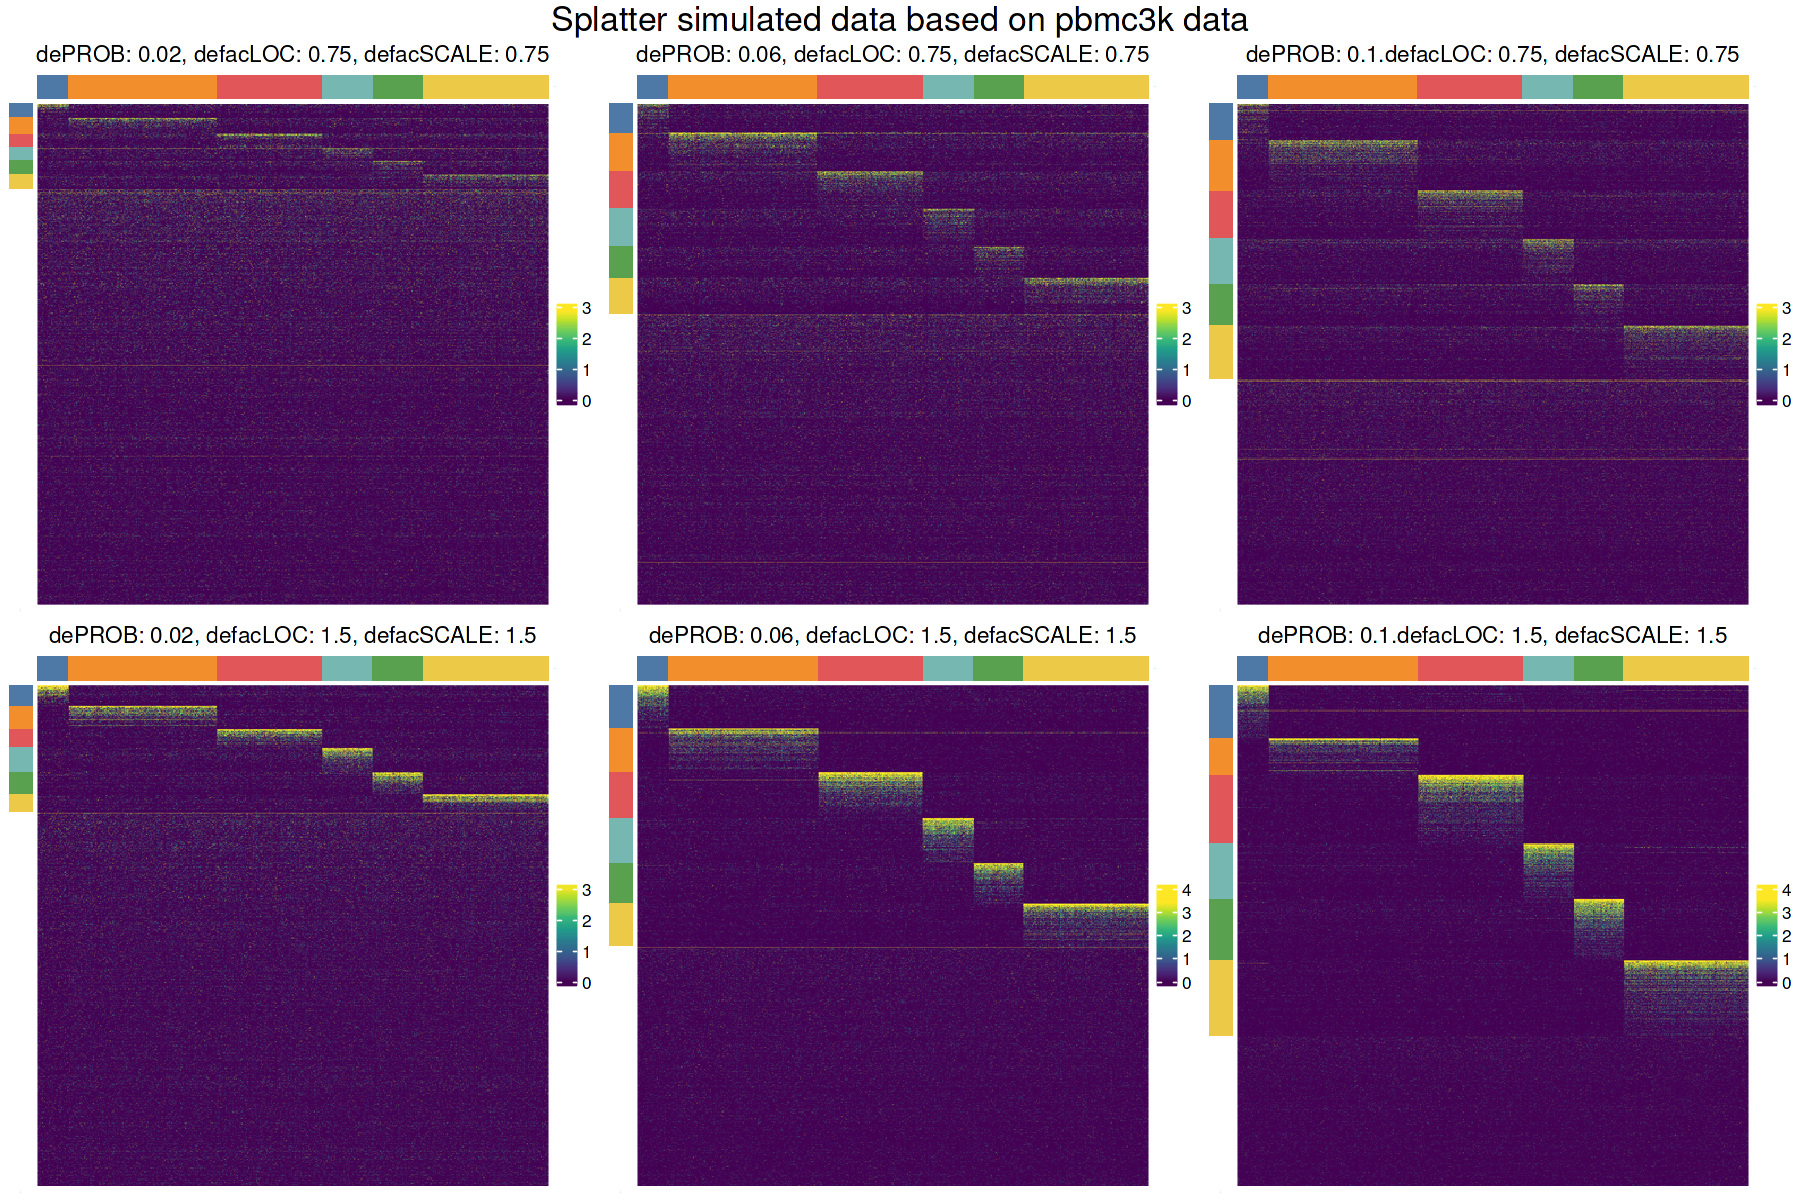

In [8]:

grob1 = grid.grabExpr(draw(phm_list$`dePROB-0_02_defacLOC-0_75_defacSCALE-0_75_filtered.rds`)) 
grob2 = grid.grabExpr(draw(phm_list$`dePROB-0_06_defacLOC-0_75_defacSCALE-0_75_filtered.rds`))
grob3 = grid.grabExpr(draw(phm_list$`dePROB-0_1_defacLOC-0_75_defacSCALE-0_75_filtered.rds`))
grob4 = grid.grabExpr(draw(phm_list$`dePROB-0_02_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))
grob5 = grid.grabExpr(draw(phm_list$`dePROB-0_06_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))
grob6 = grid.grabExpr(draw(phm_list$`dePROB-0_1_defacLOC-1_5_defacSCALE-1_5_filtered.rds`))

# png("./img/pbmc3k_hms_3cols.png",
#     width = 1200,
#     height = 600,
#     unit = "px")

grid.arrange(grob1, grob2, grob3, 
             grob4, grob5, grob6,
             top = textGrob("Splatter simulated data based on pbmc3k data",  gp=gpar(fontsize=20)),
             ncol=3, nrow =2)
# dev.off()

# R environment

In [9]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: MarIuX64 2.0 GNU/Linux

Matrix products: default
BLAS:   /pkg/R-4.2.1-0/lib/R/lib/libRblas.so
LAPACK: /pkg/R-4.2.1-0/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8 LC_NUMERIC=C         LC_TIME=C           
 [4] LC_COLLATE=C         LC_MONETARY=C        LC_MESSAGES=C       
 [7] LC_PAPER=C           LC_NAME=C            LC_ADDRESS=C        
[10] LC_TELEPHONE=C       LC_MEASUREMENT=C     LC_IDENTIFICATION=C 

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gridExtra_2.3               circlize_0.4.15            
 [3] ggthemes_4.2.4              biclust_2.0.3              
 [5] lattice_0.20-45             colorspace_2.1-0           
 [7] MASS_7.3-58                 RColorBrewer_1.1-3         
 [9] viridis_0.6.2               viridisLite_0.4.2          
[11] ComplexHeatmap_2.12.0       scran_1.